In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np
from PIL import ImageFont, ImageDraw, ImageOps
from random import randint
import matplotlib.font_manager as fm
import pandas as pd
from IPython import display
from utils import Logger
import cv2
import glob
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchsummary import summary

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class GeneratorNet(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(GeneratorNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [3]:
path_weight ='/home/vashie/DE-GAN/weight/'
model = GeneratorNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load(path_weight + 'generator-deblur-final.pt'))
model.cuda()
model.eval()

GeneratorNet(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(

In [4]:
# To Run inference on multiple data
DATA_FOLDER = '/home/vashie/DE-GAN/test/'

all_files = os.listdir(DATA_FOLDER)

all_files = sorted( all_files)
all_files_path = [os.path.join(DATA_FOLDER, filename) for filename in all_files]
all_files_df = pd.DataFrame({'path': all_files_path, 'file_name': all_files})
all_files_df.head()


,path,file_name
0,/home/vashie/DE-GAN/test/blur.jpg,blur.jpg


(162, 584)


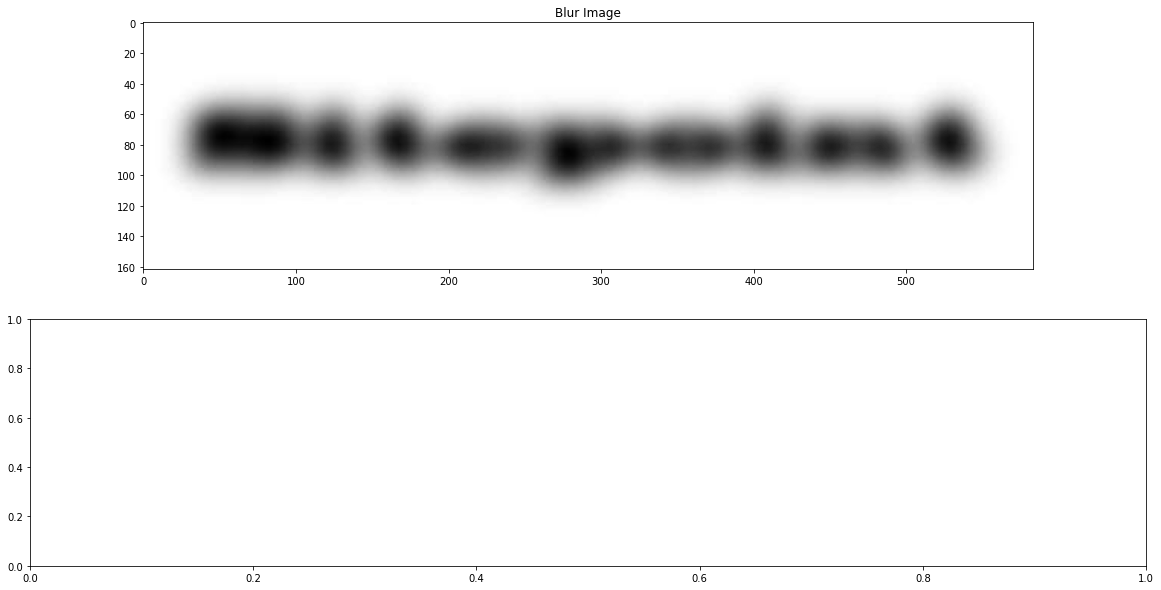

In [5]:
# Multiple Data
test_image = []
for file in all_files:
    image = np.asarray(Image.open(DATA_FOLDER+file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    original_img=test_image
    test_image.append(image)
    

print(test_image[0].shape)
_,ax = plt.subplots(2, figsize=(20,10))
ax[0].imshow(test_image[0], cmap='gray')
ax[0].title.set_text('Blur Image')
plt.show()


In [6]:
#Reshaping image to load into our GAN model
# For multiple data
test_image_p = []
for x in range(0,len(test_image)):
    h =  ((test_image[x].shape [0] // 256) +1)*256 
    w =  ((test_image[x].shape [1] // 256 ) +1)*256
    test_padding=np.zeros((h,w))+1
    test_padding[:test_image[x].shape[0],:test_image[x].shape[1]]=test_image[x]
    reshape_img=test_padding.reshape(1,h,w)
    test_image_p.append(reshape_img)

test_image_p = np.concatenate(test_image_p, axis=0)
print(test_image_p.shape)

(1, 256, 768)


In [14]:
class blur(Dataset):

  def __init__(self, test_img, transform=None):
    self.test_img = test_img
    self.transform = transform

  def __len__(self):
    return len(self.test_img)

  def __getitem__(self, idx):
    blur_image = self.test_img[idx]

    blur_image = np.asarray(blur_image)

    blur_image = Image.fromarray(blur_image.astype(np.uint8))

    if self.transform:
       blur_image = self.transform(blur_image)

    return blur_image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset = blur(test_image_p, transform=transforms.Compose(
            [transforms.ToTensor(), 
             transforms.Normalize([0.5], [0.5])]))
bs = 1
data_loader = DataLoader(dataset, batch_size=bs, shuffle=False)
num_batches = len(data_loader)


In [16]:
#Predict all the images inside the data_loader
y = []
pred_img = []
input_data = []
blur_data = []
for n_batch,data in enumerate(data_loader):
    data = data.to(device)
    input_data.append(data.detach().cpu().numpy())
    output = model(data)
    output = output.to(device)
    y.append(output.detach().cpu().numpy())
    pred_img = np.concatenate(y, axis=0)
    blur_data= np.concatenate(input_data,axis=0)


RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 1.96 GiB total capacity; 1.03 GiB already allocated; 53.06 MiB free; 1.09 GiB reserved in total by PyTorch)

In [ ]:
print(pred_img.shape)
print(blur_data.shape)

In [ ]:
#Slicing method to crop the image
#Crop all the image according to the input image size
clear_image = []
blur_image = []
for z in range(0,len(test_image)):
    temp1=pred_img[:,:,:test_image[z].shape[0],:test_image[z].shape[1]]
    temp1 = np.asarray(temp1)
    clear_image.append(temp1)
    temp2 = blur_data[:,:,:test_image[z].shape[0],:test_image[z].shape[1]]
    temp2 = np.asarray(temp2)
    blur_image.append(temp2)


In [ ]:
print(blur_image[10].shape)
print(clear_image[10].shape)

In [ ]:

_, ax = plt.subplots(1,2)
ax[0].imshow(blur_image[0][0].squeeze(), cmap='gray')
ax[0].title.set_text('Blur Image')
ax[1].imshow(clear_image[0][0].squeeze(), cmap='gray')
ax[1].title.set_text('Predicted Image')
plt.show() 



In [ ]:
#Save all the images in Clear_image folder

for x in range(0,len(clear_image)):
    save_path="/home/vashie/DE-GAN/De-blurred_image/"
    plt.imsave(save_path+'image_'+str(x)+'.png', clear_image[x][x].squeeze(),cmap='gray')
